<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/ContrastAndColor/GMM_OT_color_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Color transfer with Optimal transport between GMM

This notebook illustrates the use of the distance $GW_2$ for color transfer, as described in

[Delon, Desolneux, *A Wasserstein-type distance in the space of Gaussian Mixture Models*, 2019.](https://hal.archives-ouvertes.fr/hal-02178204)

**Authors:**
* [Julie Delon](https://github.com/judelo)



## Importing packages

Below is a list of packages needed and a brief explanation of its use in this notebook:

- `numpy` (library used for working with arrays)
- `matplotlib` (library used for working with images)
-  `scipy.linalg` (library used linear algebra functions)
- `scipy.stats` (library used for probability density functions)
- `sklearn.mixture` (library used for energy models)
- `sklearn.cluster` (library used for KMeans algorithm)
-  `ot` (Optimal Transport library https://github.com/rflamary/POT)
- `os` (library used for interact with the operating system)

In order to use the Optimal Transport library we must first install it using PIP. 

In [11]:
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg as spl
import scipy.stats as sps 
import os

import sklearn.mixture    # for EM
from sklearn.cluster import KMeans  # for kmeans

import ot                 

To import the solutions, execute the following cell.

In [13]:
#@title
from scipy.optimize import linprog

#################
### author : Julie Delon
#################

###############################
#### display GMM
###############################


def display_gmm(gmm,n=50,ax=0,bx=1,ay=0,by=1,cmap='viridis',axis=None):
    
    if axis is None:
        axis = plt.gca()
        
    [K,pi,mu,S] = gmm
    
    x = np.linspace(ax, bx,num=n)
    y = np.linspace(ay, by,num=n)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = densite_theorique2d(mu,S,pi,XX)
    Z = Z.reshape(X.shape)
    plt.axis('equal')
    return axis.contour(X, Y, Z,8,cmap=cmap)    

###############################
#### compute GMM densities
###############################

def densite_theorique(mu,var,alpha,x):
    # compute the 1D GMM density with parameters (mu,var) and weights alpha  at x 
    K=mu.shape[0]
    y=0
    #y=np.zeros(len(x))
    for j in range(K):
        y+=alpha[j]*sps.norm.pdf(x,loc=mu[j,:],scale=np.sqrt(var[j,:,:]))
    return y.reshape(x.shape)

def densite_theorique2d(mu,Sigma,alpha,x):
    # compute the 2D GMM density with parameters (mu, Sigma) and weights alpha at x
    K = mu.shape[0]
    alpha = alpha.reshape(1,K)
    y=0
    for j in range(K):
        y+=alpha[0,j]*sps.multivariate_normal.pdf(x,mean=mu[j,:],cov=Sigma[j,:,:])
    return y

###############################
### Optimal Transport between Gaussians (quadratic Wasserstein)
###############################

def GaussianW2(m0,m1,Sigma0,Sigma1):
    # compute the quadratic Wasserstein distance between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d

def GaussianMap(m0,m1,Sigma0,Sigma1,x):
    # Compute the OT map (evaluated at x) between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1 
    # m0 and m1 must be 2D arrays of size 1xd
    # Sigma0 and Sigma1 must be 2D arrays of size dxd
    # x can be a matrix of size n x d,
    # each column of x is a vector to which the function is applied
    d = Sigma0.shape[0]
    m0 = m0.reshape(1,d)
    m1 = m1.reshape(1,d)
    Sigma0 = Sigma0.reshape(d,d)
    Sigma1 = Sigma1.reshape(d,d)
    Sigma  = np.linalg.inv(Sigma0)@spl.sqrtm(Sigma0@Sigma1)
    Tx        = m1+(x-m0)@Sigma
    return Tx

def GaussianBarycenterW2(mu,Sigma,alpha,N):
    # Compute the W2 barycenter between several Gaussians
    # mu has size Kxd, with K the number of Gaussians and d the space dimension
    # Sigma has size Kxdxd
    K        = mu.shape[0]  # number of Gaussians
    d        = mu.shape[1]  # size of the space
    Sigman   = np.eye(d,d)
    mun      = np.zeros((1,d))
    cost = 0
    
    for n in range(N):
        Sigmandemi       = spl.sqrtm(Sigman)
        T = np.zeros((d,d))
        for j in range(K):
            T+= alpha[j]*spl.sqrtm(Sigmandemi@Sigma[j,:,:]@Sigmandemi)
        Sigman  = T
    
    for j in range(K):
        mun+= alpha[j]*mu[j,:]
    
    for j in range(K):
        cost+= alpha[j]*GaussianW2(mu[j,:],mun,Sigma[j,:,:],Sigman)

    return mun,Sigman,cost       # return the Gaussian Barycenter (mun,Sigman) and the total cost


###############################
###### GW2 between GMM
###############################


def GW2(pi0,pi1,mu0,mu1,S0,S1):
    # return the GW2 discrete map and the GW2 distance between two GMM
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    S0 = S0.reshape(K0,d,d)
    S1 = S1.reshape(K1,d,d)
    M  = np.zeros((K0,K1))
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    # Then we compute the OT distance or OT map thanks to the OT library
    wstar     = ot.emd(pi0,pi1,M)         # discrete transport plan
    distGW2   = np.sum(wstar*M)
    return wstar,distGW2

def GW2cost(mu0,mu1,S0,S1):       # return the distance matrix M of size K0 x K1
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    M = np.zeros((K0,K1))
    # we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    return M

def GW2_map(pi0,pi1,mu0,mu1,S0,S1,wstar,x):      
    # return the GW2 maps between two GMM on the 1D grid x  
    n,K0,K1    = x.shape[0],mu0.shape[0],mu1.shape[0]
    T          = np.zeros((K0,K1,n))     # each Tkl = T[k,l,:] is of dimension n and correspond to the W2-map between component k of mu0 and component l of mu1
    tmpmean    = np.zeros(n)
    weightmean = np.zeros(n)
    Tmean      = np.zeros((n,n))     # averaged map on a grid 
    Tmap       = np.zeros((n,n))     # multivalued map on a grid
    
    for k in range(K0):
        for l in range(K1):
            if wstar[k,l]!=0:
                T[k,l,:] = GaussianMap(mu0[k,:],mu1[l,:],S0[k,],S1[l],x).reshape(n,)
                for i in range(n):
                    Ti             = int(max(min(T[k,l,i],1),0)*99)
                    Tmap[i,Ti]    += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=np.sqrt(S0[k]))
                    tmpmean[i]    += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=np.sqrt(S0[k]))/densite_theorique(mu0,S0,pi0,x[i])*T[k,l,i]
                    weightmean[i] += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=np.sqrt(S0[k]))

    tmpmean = np.uint(np.maximum(np.minimum(tmpmean,1),0)*99)
    for i in range(n):
        Tmean[i,tmpmean[i]] = weightmean[i]
    
    return Tmap,Tmean


#####################################################
##### Multimarginal problem
#####################################################


def create_cost_matrix_from_gmm(gmm,alpha,N=10):
    """
    create the cost matrix for the multimarginal problem between all GMM
    create the barycenters (mun,Sn) betweenn all Gaussian components 
    """
    
    nMarginal       = len(alpha)               # number of marginals
    d               = gmm[0][2].shape[1]       # space dimension
    tup = ();
    for k in range(nMarginal):
        K  = gmm[k][0]
        tup+=(K,)        
    C               = np.zeros(tup)
    mun             = np.zeros(tup+(d,))
    Sn             = np.zeros(tup+(d,d))
        
    it = np.nditer(C,["multi_index"])
    while not it.finished:
        tup = it.multi_index        
        mu = np.zeros((nMarginal,d))
        Sigma = np.zeros((nMarginal,d,d))
        
        for k in range(nMarginal):
            mu[k,:]      = gmm[k][2][tup[k]]
            Sigma[k,:,:] = gmm[k][3][tup[k]]
            
        mu    = np.array(mu)    
        Sigma = np.array(Sigma)    
        [mun[tup],Sn[tup],cost] = GaussianBarycenterW2(mu,Sigma,alpha,N)
        
        C[tup] = cost
        
        it.iternext()
    
    return C,mun,Sn  

def solveMMOT(pi, costMatrix, epsilon = 1e-10):
    """ Author : Alexandre Saint-Dizier
    
    Solveur of the MultiMargnal OT problem, using linprog

    Input :
     - pi : list(array) -> weights of the different distributions
     - C : array(d1,...dp) -> cost matrix
     - epsilon : smallest value considered to be positive

    Output :
     - gamma : list of combinaison with positive weight
     - gammaWeights : corresponding weights
    """

    nMarginal = len(pi);
    nPoints = costMatrix.shape;

    nConstraints = 0; nParameters = 1;
    for ni in nPoints:
        nConstraints += ni; nParameters *= ni

    index = 0;
    A = np.zeros((nConstraints, nParameters)); b = np.zeros(nConstraints)
    for i in range(nMarginal):
        ni = nPoints[i];
        b[index:index+ni] = pi[i];
        for k in range(ni):
            Ap = np.zeros(costMatrix.shape);
            tup = ();
            for j in range(nMarginal):
                if j==i:
                    tup+= (k,)
                else:
                    tup+=(slice(0,nPoints[j]),)
            Ap[tup] = 1;
            A[index+k,:]=Ap.flatten();
        index += ni
    A = A.tolist(); b = b.tolist();
    C = costMatrix.flatten().tolist()

    res = linprog(C, A_eq=A, b_eq =b) #Solve inf <C,X> with constraints AX=b
    gammaWeights = res.x;
    gammaWeights = gammaWeights.reshape(costMatrix.shape)
   
    return gammaWeights


####################################################
#### for color transfer or color barycenters   #####
#### guided_filter is used for post-processing #####
####################################################


def average_filter(u,r):
    # uniform filter with a square (2*r+1)x(2*r+1) window
    # u is a 2d image
    # r is the radius for the filter
    
    (nrow, ncol)                                      = u.shape
    big_uint                                          = np.zeros((nrow+2*r+1,ncol+2*r+1))
    big_uint[r+1:nrow+r+1,r+1:ncol+r+1]               = u
    big_uint                                          = np.cumsum(np.cumsum(big_uint,0),1)       # integral image
    
    out = big_uint[2*r+1:nrow+2*r+1,2*r+1:ncol+2*r+1] + big_uint[0:nrow,0:ncol] - big_uint[0:nrow,2*r+1:ncol+2*r+1] - big_uint[2*r+1:nrow+2*r+1,0:ncol]
    out = out/(2*r+1)**2
    
    return out

def guided_filter(u,guide,r,eps):
    C           = average_filter(np.ones(u.shape), r)   # to avoid image edges pb
    mean_u      = average_filter(u, r)/C
    mean_guide  = average_filter(guide, r)/C
    corr_guide  = average_filter(guide*guide, r)/C
    corr_uguide = average_filter(u*guide, r)/C
    var_guide   = corr_guide - mean_guide * mean_guide
    cov_uguide  = corr_uguide - mean_u * mean_guide
    
    alph = cov_uguide / (var_guide + eps)
    beta = mean_u - alph * mean_guide
    
    mean_alph = average_filter(alph, r)/C
    mean_beta = average_filter(beta, r)/C
    
    q = mean_alph * guide + mean_beta
    return q

# Discrete Optimal Transport between Gaussian Mixtures

## Color transfer with GMM-OT

We read two color images into numpy arrays.
Be careful that jpg images must be cast to double and normalized to [0,1]. 

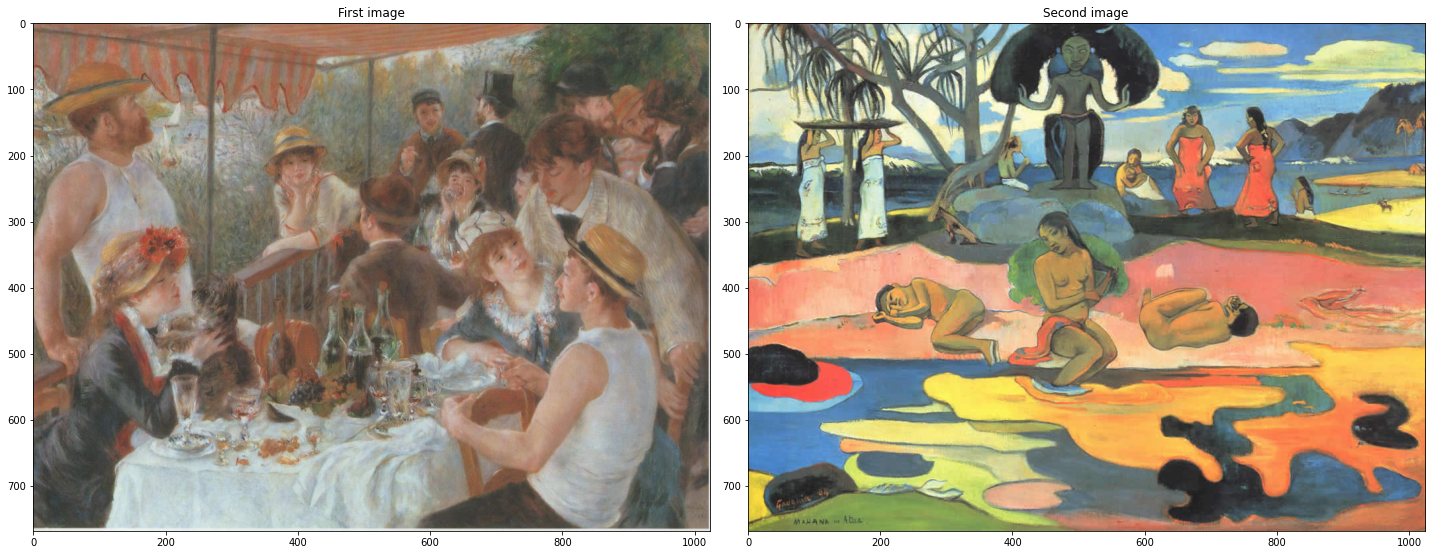

In [16]:
os.system("wget -c https://raw.githubusercontent.com/judelo/notebooks/master/im/renoir.jpg")
os.system("wget -c https://raw.githubusercontent.com/judelo/notebooks/master/im/gauguin.jpg")

#ATTENTION : if images are of type jpg or bmp, they should be normalized to [0,1] 
u = plt.imread('renoir.jpg')/255
v = plt.imread('gauguin.jpg')/255
nru,ncu,nch = u.shape
nrv,ncv,nch = v.shape

# image display thanks to the function imshow of the pyplot library of matplotlib
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))

#we display the images
axes[0].imshow(u)
axes[0].set_title('First image')
axes[1].imshow(v)
axes[1].set_title('Second image')
fig.tight_layout()

We display their 3D color scatter plots.

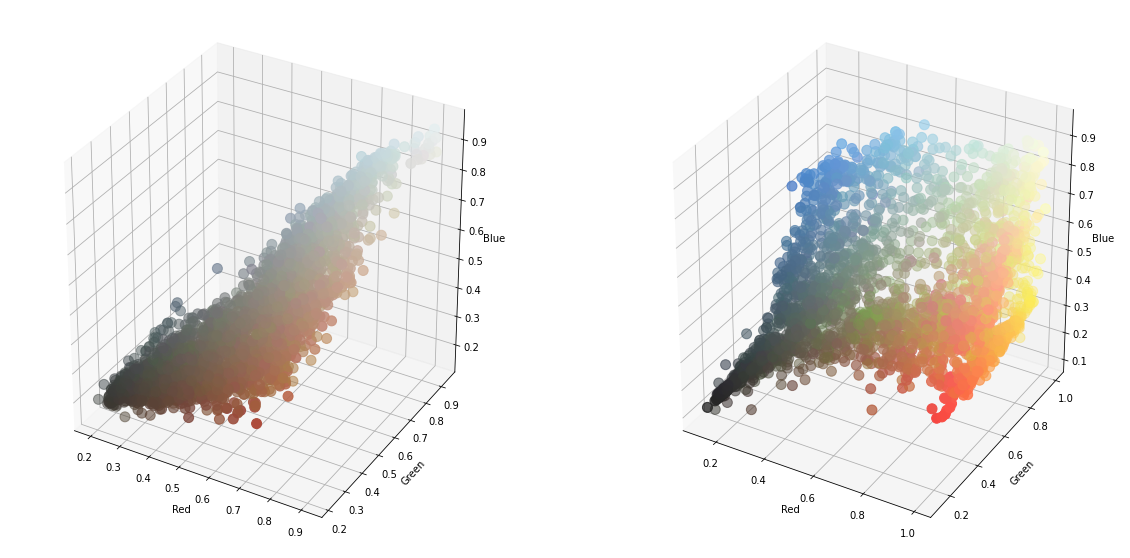

In [17]:
X = u.reshape((nru*ncu,3))
Y = v.reshape((nrv*ncv,3))
nb   = 3000
r    = np.random.RandomState(42)
idX  = r.randint(X.shape[0], size=(nb,))
idY  = r.randint(Y.shape[0], size=(nb,))
Xs   = X[idX, :]
Ys   = Y[idY, :]

fig  = plt.figure(2, figsize=(20, 10))
axis = fig.add_subplot(1, 2, 1, projection="3d")
axis.scatter(Xs[:, 0], Xs[:,1],Xs[:, 2], c=Xs,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(Ys[:, 0], Ys[:,1],Ys[:, 2], c=Ys,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");


### Separable optimal transport

First, we show the result of separable optimal transport (implemented here for two images of the same size).

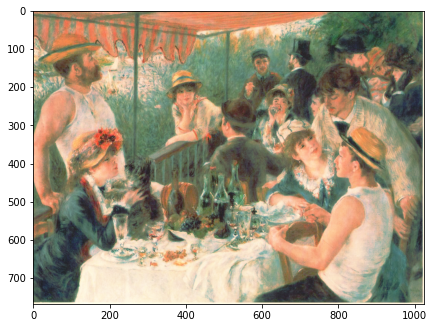

In [18]:
# BE CAREFUL: this implementation works only if u and v have the same size
uout = np.copy(u)

for k in range(3):
    uk = u[:,:,k]
    vk = v[:,:,k]   
    uk_sort,index_u=np.sort(uk,axis=None),np.argsort(uk,axis=None)
    vk_sort,index_v=np.sort(vk,axis=None),np.argsort(vk,axis=None)
    uspecifv= np.zeros(nru*ncu)
    uspecifv[index_u] = vk_sort
    uspecifv = uspecifv.reshape(nru,ncu)
    uout[:,:,k] = uspecifv

#Display images
plt.figure(figsize=(7, 7))
plt.imshow(uout)

### Estimating the GMM with scikit-learn 

We use scikit-learn to compute the GMM from the two color 3d point clouds.

In [19]:
X = u.reshape((nru*ncu,3))
Y = v.reshape((nrv*ncv,3))
k = 10 # number of classes
ninit = 1
K0,K1 = k,k
gmmX = sklearn.mixture.GaussianMixture(n_components=K0, covariance_type='full',n_init=ninit).fit(X) # spherical or full 
pi0,mu0,S0 = gmmX.weights_, gmmX.means_, gmmX.covariances_ 
ClassesX = gmmX.predict(X) 
ProbaClassesX = gmmX.predict_proba(X) 

gmmY = sklearn.mixture.GaussianMixture(n_components=K1, covariance_type='full',n_init=ninit).fit(Y)  # spherical or full 
pi1,mu1,S1 = gmmY.weights_, gmmY.means_, gmmY.covariances_ 
ClassesY = gmmY.predict(Y) 
ProbaClassesY = gmmY.predict_proba(Y)

We can display the following classes on the scatter plots.

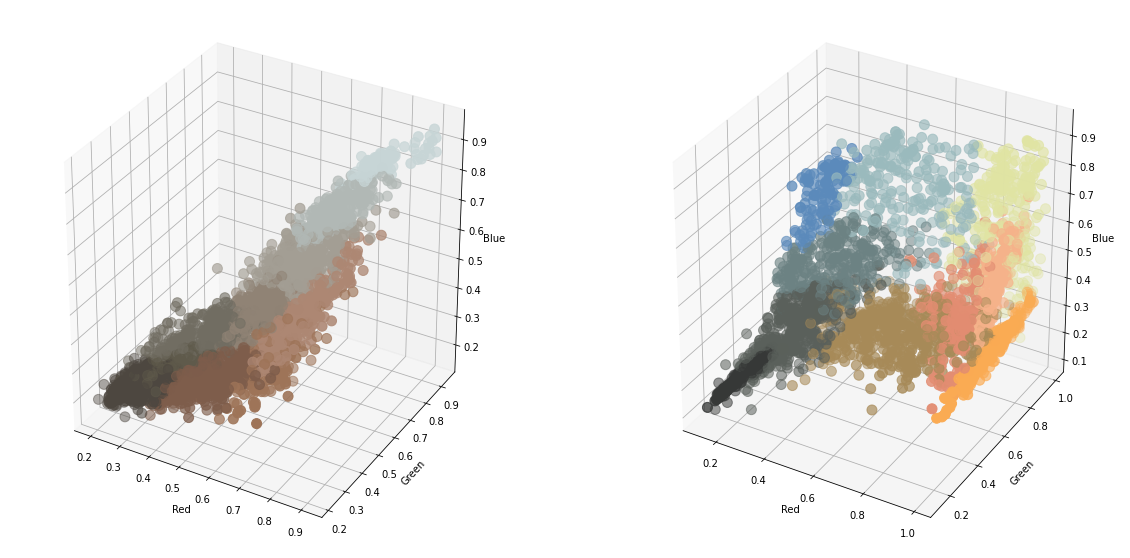

In [20]:
nb   = 3000
r    = np.random.RandomState(42)
idX  = r.randint(X.shape[0], size=(nb,))
idY  = r.randint(Y.shape[0], size=(nb,))
Xs   = X[idX, :]
Ys   = Y[idY, :]
ClassesXsubsample = ClassesX[idX]
ClassesYsubsample = ClassesY[idY]

fig  = plt.figure(2, figsize=(20, 10))
axis = fig.add_subplot(1, 2, 1, projection="3d")
axis.scatter(Xs[:, 0], Xs[:,1],Xs[:, 2], c=mu0[ClassesXsubsample,:],s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(Ys[:, 0], Ys[:,1],Ys[:, 2], c=mu1[ClassesYsubsample,:],s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");

We can also display the segmentations of $u$ and $v$ provided by the GMM (the color of pixels of the same class is the mean of the class)

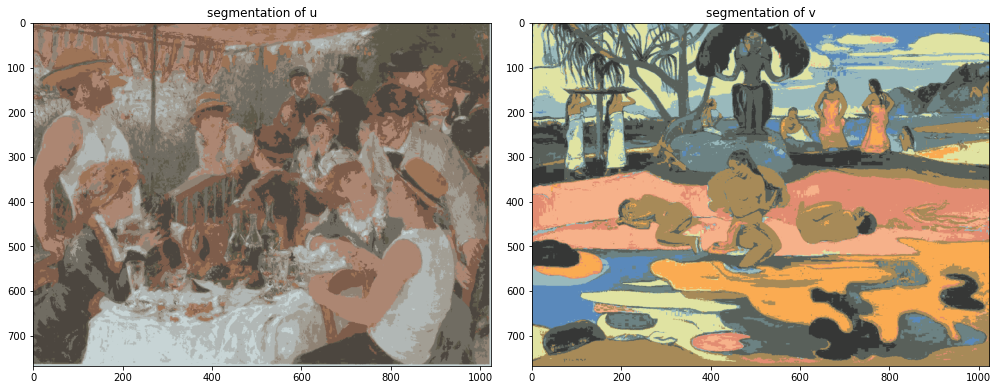

In [21]:
# display the corresponding image segmentations
useg = mu0[ClassesX]
useg = useg.reshape((nru,ncu,3))
vseg = mu1[ClassesY]
vseg = vseg.reshape((nrv,ncv,3))
# display
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].imshow(useg)
axes[0].set_title('segmentation of u')
axes[1].imshow(vseg)
axes[1].set_title('segmentation of v')
fig.tight_layout()

### Use GW2 for color transfer 

Then, we can use the GW2 transport map between these two GMM for color transfer.

In [22]:
# Compute the K0xK1 OT matrix between the members of the mixtures
wstar,dist = GW2(pi0/np.sum(pi0),pi1/np.sum(pi1),mu0,mu1,S0,S1)

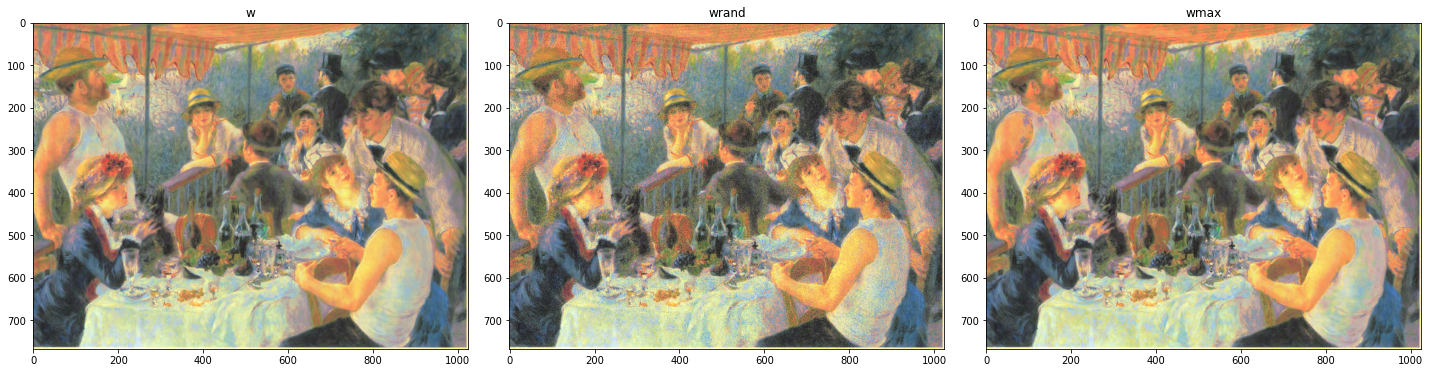

In [23]:
# Compute all Tkl maps at all points of u 
T = np.zeros((K0,K1,3,nru*ncu))
for k in range(K0):
        for l in range(K1):
            T[k,l,:,:] = GaussianMap(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:],X).T   
            
# Compute mean color transfer on all points
Tmeanx = np.zeros((3,nru*ncu))
for k in range(K0):
    for l in range(K1):
        Tmeanx += wstar[k,l]/pi0[k]*ProbaClassesX[:,k].T*T[k,l,:,:]
                
# Compute random color transfer on all points (random sample with posterior distribution)
Trandx = np.zeros((3,nru*ncu))
tmp = np.zeros((K0*K1,nru*ncu))
for k in range(K0):
    for l in range(K1):
        tmp[k+K0*l,:]= wstar[k,l]/pi0[k]*ProbaClassesX[:,k]
for i in range(nru*ncu):
    m = np.random.choice(K0*K1,p=tmp[:,i])
    l = m//K0
    k = m - K0*l
    Trandx[:,i] = T[k,l,:,i]        

    
# Compute best color transfer on all points (only best class for each point)
Tmaxx = np.zeros((3,nru*ncu))
normalisation = np.zeros((nru*ncu))
for k in range(K0):
    for l in range(K1):
        Tmaxx += wstar[k,l]*T[k,l,:,:]*(ClassesX==k).T
        normalisation +=wstar[k,l]*(ClassesX==k).T
Tmaxx = Tmaxx/normalisation


# Display result as an image
w=Tmeanx.T.reshape((nru,ncu,3))
wmax=Tmaxx.T.reshape((nru,ncu,3))
wrand=Trandx.T.reshape((nru,ncu,3))


#we display the images
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axes[0].imshow(w)
axes[0].set_title('w')
axes[1].imshow(wrand)
axes[1].set_title('wrand')
axes[2].imshow(wmax)
axes[2].set_title('wmax')
fig.tight_layout()

# Result regularization (optionnal)

A common drawback of classical methods aiming at color and contrast modifications is the revealing of artefacts (JPEG blocs, color inconsistancies, noise enhancement) or the attenuation of details and textures (see for instance the following [web page](http://perso.telecom-paristech.fr/~delon/artefact_removal_html/)). 
Let $u$ be an image and $g(u)$ the same  image after color or contrast modification, we write $\mathcal{M}(u) = g(u) - u$. All artefacts observable in $g(u)$ can be seen as irregularities in these difference map $\mathcal{M}(u)$. In order to reduce these artefacts, we propose to filter this difference map thanks to an operator $Y_u$ and to reconstruct the image:

$$T(g(u)) = u + Y_u(g(u)-u).$$

We will use for $Y_u$ the guided filter described in the paper

[*Guided Image Filtering*, Kaiming He1, Jian Sun2, and Xiaoou Tang, ECCV 2010.](http://kaiminghe.com/publications/eccv10guidedfilter.pdf)


In [24]:
diff = w-u
out = np.zeros_like(u)

for i in range(3):
    out[:,:,i] = guided_filter(diff[:,:,i],u[:,:,i], 10,1e-4 )

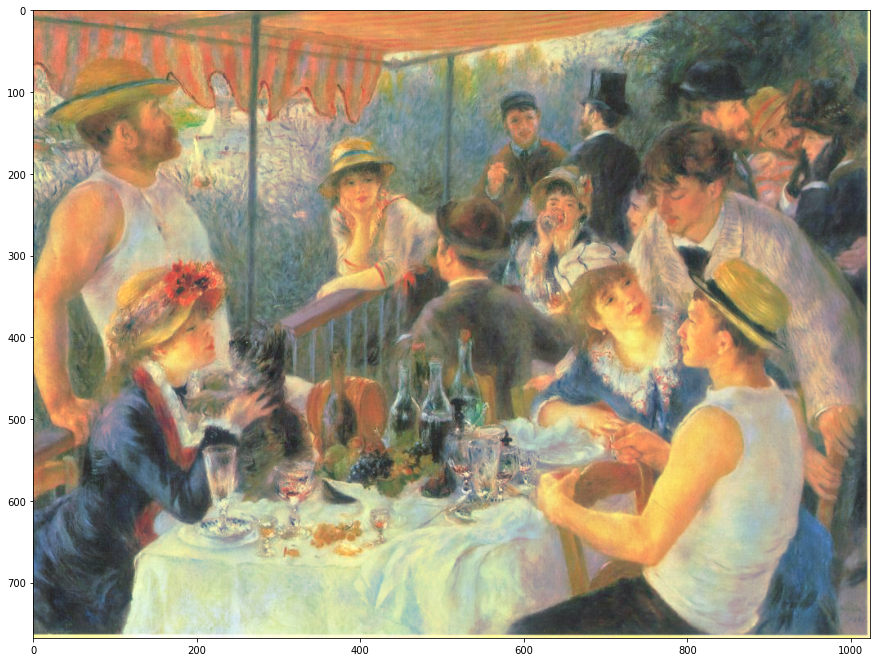

In [25]:
#we display the result
plt.figure(figsize=(15, 15))
plt.imshow(out+u)